In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from medmnist import PneumoniaMNIST

In [2]:
dataset = PneumoniaMNIST(split="train", download=True)
type(dataset)


Using downloaded and verified file: /Users/karol/.medmnist/pneumoniamnist.npz


medmnist.dataset.PneumoniaMNIST

In [3]:

# load the data
train_dataset = PneumoniaMNIST(split='train', download = True)
test_dataset = PneumoniaMNIST(split='test', download = True)
print(len(train_dataset), len(test_dataset))

Using downloaded and verified file: /Users/karol/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/karol/.medmnist/pneumoniamnist.npz
4708 624


/Users/karol/anaconda3/lib/python3.10/site-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


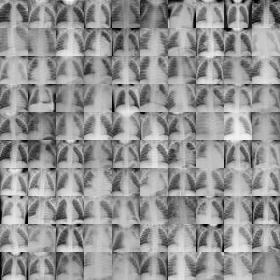

In [4]:
train_dataset.montage(10)

#### Zdjęcie rentgenowskie zdrowej osoby

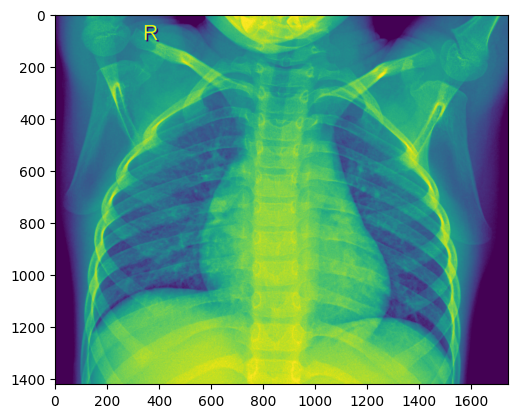

In [5]:
img = Image.open('photo1.jpeg')
plt.imshow(img)
plt.show()

#### Obserwacja: 

Na powyższym zdjęciu nie widzimy rozmytych struktur - są to płuca zdrowego pacjenta.

#### Zdjęcie rentgenowskie osoby z zapaleniem płuc

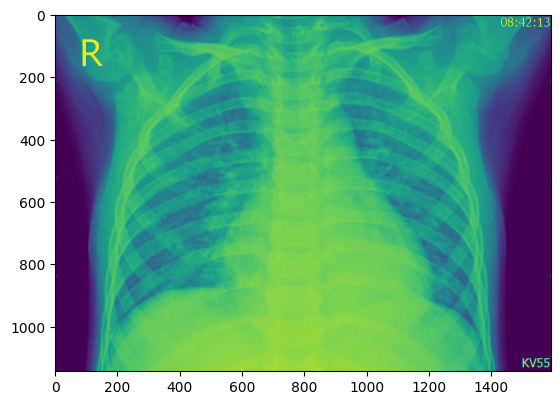

In [6]:
img = Image.open('photo2.jpeg')
plt.imshow(img)
plt.show()

#### Obserwacja:

Na powyższym zdjęciu widimy, że ostrość zdjęcia jest zaburzona - są to płuca osoby cierpiącej na zapalenie

#### Zamiana jpeg na tensor liczbowy 

W celu wytrenowania konwolucyjnej sieci neuronowej na zdjęciach rentgenowskich format analizowanych obiektów został zamieniony na piksele.

Metoda wykorzystana do konwersji zdjęć na piksele to <b>interpolacja dwuliniowa</b>.

In [7]:
# small_img=img.resize((32,32),Image.BILINEAR)
# img_array = np.array(small_img)


# 
def store_pictures(dir_path) -> np.array:
    images = []
    for filename in os.listdir(dir_path):
        
        if filename.endswith('.jpeg'):
            img = Image.open(os.path.join(dir_path, filename))
            width, height = img.size # zmiana tutaj! - UWAGA Problem - wprowadzam różne rozmiary jpegow
#             print(width, height)
            small_img=img.resize((128, 128),Image.BILINEAR)
            img_array = np.array(small_img)
            
        
            images.append(img_array)
            
    return np.array(images)



# Jak ma wyglądać ten adaptive pooling?


# import numpy as np
# import os
# from PIL import Image
# import torch
# import torch.nn as nn

# def store_pictures(dir_path):
#     images = []
#     for filename in os.listdir(dir_path):
#         if filename.endswith('.jpeg'):
#             img = Image.open(os.path.join(dir_path, filename))

#             # zmieńmy rozmiar obrazu do (128, 128) dla przykładu
#             small_img = img.resize((128, 128), Image.BILINEAR)
            
#             # konwersja do numpy array i normalizacja do przedziału [0, 1]
#             img_array = np.array(small_img) / 255.0

#             # konwersja do PyTorch tensora
#             img_tensor = torch.from_numpy(img_array)

#             # dodajemy dodatkowe wymiary
#             img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)

#             # adaptive pooling
#             pool = nn.AdaptiveMaxPool2d(1)
#             output = pool(img_tensor)
            
#             print(output.shape)  # powinno zwrócić [1, 1, 1, 1]
#             images.append(output.numpy())
            
#     return images





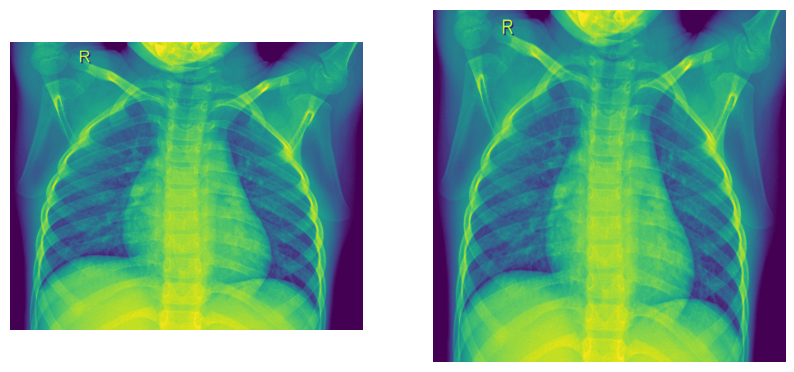

In [8]:
img1 = Image.open('photo1.jpeg')
img1_pixeled = img1.resize((1000,1000), Image.BILINEAR)

# adaptive pooling - warstwy zmniejszające wymiarowość, ale uczą się jak to robić
# PADDING - maksymalny rozmiar
# piątek

plt.figure(figsize=(10, 10))

_ = plt.subplot(1, 2, 1)  
plt.imshow(img1)
plt.axis('off')

_ = plt.subplot(1, 2, 2)
plt.imshow(img1_pixeled)
plt.axis('off')

plt.show()

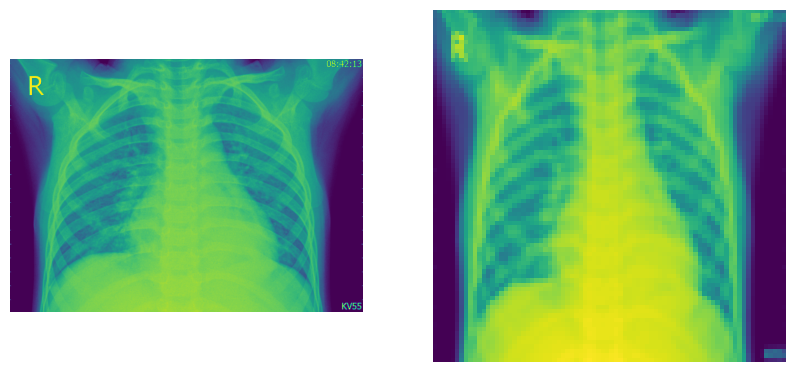

In [9]:
img2 = Image.open('photo2.jpeg')
img2_pixeled=img2.resize((80,80),Image.BILINEAR)

plt.figure(figsize=(10, 10))

_ = plt.subplot(1, 2, 1)  
plt.imshow(img2)
plt.axis('off')

_ = plt.subplot(1, 2, 2)
plt.imshow(img2_pixeled)
plt.axis('off')

plt.show()

In [11]:
normal_images_train = store_pictures('/Users/karol/python_projects/dataset/chest_xray/train/NORMAL')
sick_images_train = store_pictures('/Users/karol/python_projects/dataset/chest_xray/train/PNEUMONIA')

normal_images_test = store_pictures('/Users/karol/python_projects/dataset/chest_xray/test/NORMAL')
sick_images_test = store_pictures('/Users/karol/python_projects/dataset/chest_xray/test/PNEUMONIA')



In [12]:
X_train = np.concatenate((normal_images_train, sick_images_train), axis =0)
X_train = np.expand_dims(X_train, axis =-1)
X_test = X_test = np.concatenate((normal_images_test, sick_images_test), axis =0)
X_test = np.expand_dims(X_test, axis =-1)

In [13]:
# !pip install numpy==1.21.1
X_test.shape


(327, 128, 128, 1)

In [14]:
def generate_label(number, name_of_label_array) -> np.ndarray:
    label = np.repeat(number,len(name_of_label_array))
    return label

In [15]:
zeros = generate_label(0, normal_images_train)
ones = generate_label(1, sick_images_train)
y_train = np.concatenate((zeros, ones), axis=0)
print(len(zeros), len(ones))

1349 120


In [16]:
zeros = generate_label(0, normal_images_test)
ones = generate_label(1, sick_images_test)
y_test = np.concatenate((zeros, ones), axis=0)
print(len(zeros), len(ones))

234 93


In [17]:
X_train = X_train/255
X_test = X_test/255

In [30]:
from keras import models, layers, regularizers

cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer=regularizers.l2(0.01) ),
    #layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])


In [33]:
from sklearn.utils.class_weight import compute_sample_weight

# obliczanie wag 
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train, y_train, epochs=20, sample_weight=sample_weights)



Epoch 1/20
46/46 [==============================] - 40s 856ms/step - loss: 11.9840 - accuracy: 0.3390
Epoch 2/20
46/46 [==============================] - 39s 841ms/step - loss: 4.9900 - accuracy: 0.5984
Epoch 3/20
46/46 [==============================] - 38s 834ms/step - loss: 3.1883 - accuracy: 0.6528
Epoch 4/20
46/46 [==============================] - 39s 838ms/step - loss: 2.1511 - accuracy: 0.8516
Epoch 5/20
46/46 [==============================] - 38s 834ms/step - loss: 1.7685 - accuracy: 0.9020
Epoch 6/20
46/46 [==============================] - 38s 831ms/step - loss: 1.5519 - accuracy: 0.9006
Epoch 7/20
46/46 [==============================] - 43s 928ms/step - loss: 1.4019 - accuracy: 0.9190
Epoch 8/20
46/46 [==============================] - 41s 887ms/step - loss: 1.2634 - accuracy: 0.9299
Epoch 9/20
46/46 [==============================] - 39s 854ms/step - loss: 1.1644 - accuracy: 0.9394
Epoch 10/20
46/46 [==============================] - 38s 836ms/step - loss: 1.0293 - accur

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = cnn.predict(X_test)
Y_pred_classes = [np.argmax(element) for element in y_pred]

print('Classification Report: \n', classification_report(y_test, Y_pred_classes))
X_train.shape

# Momentum dorzucić i poeksperymentować z tą siecią
# Augmentacja zbioru danych -> randomowe rotacje o 5,10 stopni, random cropy, eksperymentować -> niszczyć zdjęcia i tworzyć na podstawie nich nowe datasety


11/11 [==============================] - 2s 166ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.71      0.75       234
           1       0.42      0.53      0.47        93

    accuracy                           0.66       327
   macro avg       0.61      0.62      0.61       327
weighted avg       0.69      0.66      0.67       327



(1469, 128, 128, 1)

In [29]:
predicted_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, predicted_labels)
print(cm)


[[209  25]
 [ 58  35]]


In [8]:
width, height = img1.size
img1_resized = store_pictures('/Users/karol/python_projects')
# img1.resize((1000,1000), Image.BILINEAR)
print(img1_resized.shape)




NameError: name 'img1' is not defined

In [9]:
# def to_tensor(dataset):
#     my_array = []
#     for i in range(len(dataset)):
#         small_img=train_dataset.montage().resize((128, 128),Image.BILINEAR)
#         img_array = np.array(small_img)        
#     my_array.append(img_array)




In [10]:
my_array = []
small_img=train_dataset.montage(2).resize((128, 128),Image.BILINEAR)
img_array = np.array(small_img)
my_array.append(img_array)

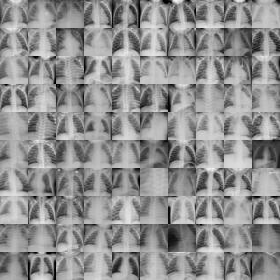

In [11]:
train_dataset.montage(10)

(-0.5, 999.5, 999.5, -0.5)

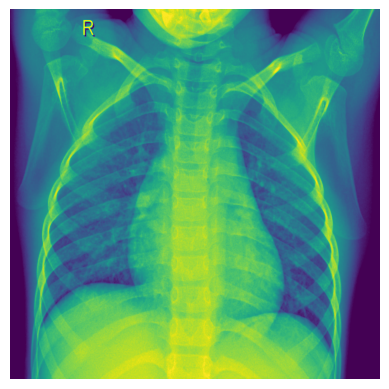

In [41]:
img1 = Image.open('photo1.jpeg')
img1_pixeled = img1.resize((1000,1000), Image.BILINEAR)
plt.imshow(img1_pixeled)
plt.axis('off')

(-0.5, 999.5, 999.5, -0.5)

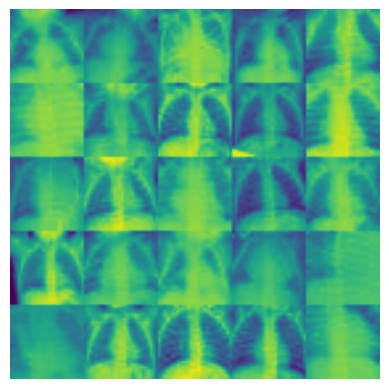

In [45]:
img1_pixeled = train_dataset.montage(5).resize((1000,1000), Image.BILINEAR)
plt.imshow(img1_pixeled)
plt.axis('off')
